# Assignment 2

**Name:** Dinglu Pan  
**Email:** dinglupa@usc.edu  
**USC ID:** 6564-8915-51  
**Setting Picked:** 1, 2, and 3

In [969]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    #return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [970]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import graphviz as gr
random.seed(10)

style.use("fivethirtyeight")

### Modified the fn_generate_data() 

In [971]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):

    nvar = p+2 # 1 confounder and variable for randomizing treatment

    if conf==False:
        conf_mult = 0 
    else:
        conf_mult = 1 
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates contained in DGP Y
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*100*C+err  
    
    if flagX==False and conf==True:     
        return (Yab,T,C)
    elif flagX==False and conf==False:
        return (Yab,T)
    elif flagX==True and conf==True:
        return (Yab,T,C,X[:, :p0])
#    elif flagX==True & conf==False:
#         return (Yab,T,X[:,:p0])
    else:                
        return (Yab,T,X[:,:p0])

# 1. Setting 1: Covariates

## 1) DGP

##### Simulate a DGP where the outcome depends on a randomly assigned treatment and some observed covariates

$Y_i = \tau*T_i+\beta'*X_i+e_i$

In [972]:
# parameters settings
tau = 6  # true treatment effect
N = 1000  # sample size
p = 10  # number of covariates generated
p0 = 3  # number of covariates used in DGP Y
corr = .5  # correlation between covariates
conf = False  # set no confounder
flagX = True  # set to return X

In [973]:
# DGP
data_1 = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
a = pd.DataFrame(data_1[0])
b = pd.DataFrame(data_1[1])
c = pd.DataFrame(data_1[2])
data_1 = pd.concat([a,b,c],axis=1)
data_1.columns = ['Y','T','X1','X2','X3']
data_1.to_csv('data_1.csv')

In [974]:
data_1


,Y,T,X1,X2,X3
0,-0.300295,0,0.338467,-0.074183,-0.091083
1,-2.330224,0,0.624934,-0.140454,-0.719742
2,37.184564,1,1.192307,2.052454,1.254532
3,-13.010052,0,-0.503960,-0.575186,-1.224354
4,12.515508,1,0.451983,0.696038,-0.400969
...,...,...,...,...,...
995,7.495350,1,1.597378,0.096760,-0.593935
996,-24.380815,1,-1.505287,-2.239106,-0.696565
997,9.763822,1,-0.184693,0.244398,-0.129824
998,8.750571,1,0.716575,-0.116522,0.669510


## 2) DAG

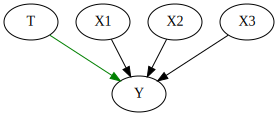

In [975]:
g = gr.Digraph()
# g.node("T", color="gold")
# g.node("Y", color="gold")
g.edge("T", "Y", color = 'green')
g.edge("X1", "Y")
g.edge("X2", "Y")
g.edge("X3", "Y")
g

## 3) Monte-Carlo experiment

### Parameters settings

In [976]:
tau = 6  # true treatment effect
p = 10  # number of covariates generated
p0 = 3  # number of covariates used in DGP Y
corr = .5  # correlation between covariates
conf = False  # no confounder
flagX = True # Also return X in DGP

First running 2 simple OLS regression under 'a' & 'b' conditions 

In [977]:
N = 100
const = np.ones([N, 1])
Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

model_a = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))  # under 'a' condition: not control for any covariates
reg_a = model_a.fit()

model_b = sm.OLS(Yexp,np.concatenate([T,X,const],axis = 1)) # under 'b' condition: control for all covariates
reg_b = model_b.fit()

print('Reg under condition "a": x1 is the treatment(i.e. T)','\n',reg_a.summary().tables[1],'\n')
print('Reg under condition "b": x1 is the treatment(i.e. T)','\n',reg_b.summary().tables[1])

Reg under condition "a": x1 is the treatment(i.e. T) 
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             9.9298      7.374      1.347      0.181      -4.704      24.564
const         -5.3301      5.215     -1.022      0.309     -15.678       5.018

Reg under condition "b": x1 is the treatment(i.e. T) 
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.9238      0.193     30.625      0.000       5.540       6.308
x2            10.1672      0.130     78.049      0.000       9.909      10.426
x3            15.1898      0.127    119.548      0.000      14.938      15.442
x4            15.1576      0.184     82.415      0.000      14.792      15.523
const         -0.0135      0.138     -0.098      0.922      -0.288       0.261


We can see that after controlling for all covariates, estimated treatment effect is closer to its true value and with higher statistic significance

### a. Not control for any covariates

In [978]:
# using the same parameters
estDict = {}  
R = 2000  # iteration times for each sample size

for N in [100, 1000]: 
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)): 
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))  # not controlling for any covariates
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 129.88it/s]


In [979]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.025278995682365378, RMSE=3.013159580431697, size=0.057
N=1000: bias=0.021407864984808612, RMSE=0.9123660714419797, size=0.0455


### b. Control for all the covariates that affect the outcome

In [980]:
# using the same parameters
estDict = {}  
R = 2000  

for N in [100, 1000]:
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)):  
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,X,const],axis = 1))  # controlling for all covariates
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 131.56it/s]


In [981]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0035249623379548624, RMSE=0.19629495727456284, size=0.052
N=1000: bias=0.0005360280854421515, RMSE=0.06454794666147642, size=0.0565


**Compareing the one without controlling for the covariates (a.), the RMSE is much smaller when we condition on those 3 covariates and with higher statistic significance (b.)**

## 4) Real-life situation example

Suppose the outcome is **wage**, the treatment is **gender**, we want to learn the effect of gender on wage. There are three observed covariates that affect the outcome but can be assumed to not related to the treatment: **age, GDP** and **marital status**. 

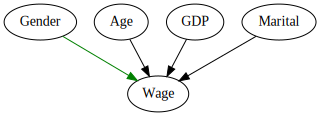

In [983]:
g = gr.Digraph()
g.edge("Gender", "Wage", color = 'green')
g.edge("Age", "Wage")
g.edge("GDP", "Wage")
g.edge("Marital", "Wage")
g

# 2. Setting 2: Confounder

## 1) DGP

##### Simulate a DGP with a confounder

$Y_i = \tau*T_i+100*C+e_i$

In [238]:
# parameters settings
tau = 3  # true treatment effect
N = 2000  # sample size
p = 10  # number of covariates generated
p0 = 0  # number of covariates used in DGP Y
corr = .5  # correlation between covariates
conf = True  # set a confounder
flagX = False 

In [239]:
# DGP
data_2 = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
a = pd.DataFrame(data_2[0])
b = pd.DataFrame(data_2[1])
c = pd.DataFrame(data_2[2])
data_2 = pd.concat([a,b,c],axis=1)
data_2.columns = ['Y','T','Confounder']
data_2.to_csv('data_2.csv')

In [240]:
data_2

,Y,T,Confounder
0,-80.629721,0,-0.802834
1,-88.321390,0,-0.885822
2,117.872907,0,1.176000
3,-29.007586,1,-0.304892
4,-59.413026,1,-0.621633
...,...,...,...
1995,-77.716126,1,-0.799352
1996,-24.671064,0,-0.251831
1997,-20.274364,1,-0.240050
1998,-161.367903,1,-1.615899


## 2) DAG

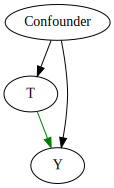

In [241]:
g = gr.Digraph()
g.edge("T", "Y", color = 'green')
g.edge("Confounder", "Y")
g.edge("Confounder", "T")
g

## 3) Monte-Carlo experiment

### Parameters settings

In [242]:
tau = 3  # true treatment effect
p = 10  # number of covariates generated
p0 = 0  # number of covariates used in DGP Y
corr = .5  # correlation between covariates
conf = True
flagX = False 

First running 2 simple OLS regression under 'a' & 'b' conditions 

In [246]:
N = 100
const = np.ones([N, 1])
Yexp,T,C = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

model_a = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))  # under 'a' condition: not control for the confounder
reg_a = model_a.fit()

model_b = sm.OLS(Yexp,np.concatenate([T,C,const],axis = 1)) # under 'b' condition: control for the confounder
reg_b = model_b.fit()

print('Reg under condition "a": x1 is the treatment(i.e. T)','\n',reg_a.summary().tables[1],'\n')
print('Reg under condition "b": x1 is the treatment(i.e. T)','\n',reg_b.summary().tables[1])

Reg under condition "a": x1 is the treatment(i.e. T) 
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -22.0961     22.639     -0.976      0.331     -67.022      22.830
const         30.8865     16.008      1.929      0.057      -0.881      62.654

Reg under condition "b": x1 is the treatment(i.e. T) 
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.9736      0.194     15.299      0.000       2.588       3.359
x2           100.0796      0.086   1160.172      0.000      99.908     100.251
const          0.0255      0.139      0.183      0.855      -0.251       0.302


We can see that after controlling for the confounder, estimated treatment effect is closer to its true value and with much higher statistic significance

### a. Not control for the confounder

In [247]:
# using the same parameters
estDict = {}  
R = 2000  

for N in [100, 1000]:
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)):  
        Yexp,T,C = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))  # not controlling for the confounder
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 131.76it/s]


In [248]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0545149900307342, RMSE=20.022527674919274, size=0.0485
N=1000: bias=-0.1877485503117604, RMSE=6.4083750249780564, size=0.048


### b. Control for the confounder

In [249]:
# using the same parameters
estDict = {}  
R = 2000  

for N in [100, 1000]:
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)):  
        Yexp,T,C = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,C,const],axis = 1))  # controlling for the confounder
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:15<00:00, 128.81it/s]


In [250]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.004791627562498931, RMSE=0.20276885120618418, size=0.0515
N=1000: bias=-0.00039081527267983686, RMSE=0.06354678808531504, size=0.0575


**Compareing the one without controlling for the confounder (a.), the RMSE is much smaller when we condition on the confounder (b.)**

## 4) Real-life situation example

Considering a situationg where we want to learn the treatment effect of **passing the college entry exam** on the college **GPA**, student's **ability** will affect the result of the entry exam and also affect the performance in college studying thus affect the GPA. Then ability will be a confounder in this situation and we need to control for it to get a precise estimator of the treatment effect

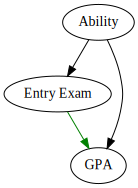

In [251]:
g = gr.Digraph()
g.edge("Entry Exam", "GPA", color = 'green')
g.edge("Ability", "GPA")
g.edge("Ability", "Entry Exam")
g

# 3. Setting 3: Selection Bias

## 1) DGP

##### Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

$Y_i = \tau*T_i+\lambda*Xsb_i+\beta*X1_i+e_i$

### Redefining the DGP function under the selection bias setting

In [940]:
def fn_gen_data(tau,N,p,p0,corr,conf = True,flagX = False):

    nvar = p+2 # 1 confounder and variable for randomizing treatment

    if conf==False:
        conf_mult = 0 
    else:
        conf_mult = 1 
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    # set X_sb is affected by T
    u = np.random.normal(0,1,[N,1])
    tmp = random.sample(range(N), round(N*0.4))
    Xsb = np.array([(1 if i in tmp and T[i]==1 else 0) for i in range(N)]).reshape([N,1])
    Xsb = Xsb+36*T+u
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*100*C+0.003*Xsb+err # assume the effect of Xsb on Y is 0.003
    
    if flagX==False and conf==True:
        return (Yab,T,Xsb,C)
    elif flagX==False and conf==False:
        return (Yab,T,Xsb)
    elif flagX==True and conf==True:
        return (Yab,T,Xsb,C,X[:, :p0])
    else:
        return (Yab,T,Xsb,X[:,:p0])

In [941]:
# parameters settings
tau = -8  # true treatment effect
N = 1000  # sample size
p = 10  # number of covariates generated
p0 = 1  # number of covariates used in DGP Y
corr = .5  # correlation between covariates
conf = False  # no confounder
flagX = True

In [942]:
# DGP
data_3 = fn_gen_data(tau,N,p,p0,corr,conf,flagX)
a = pd.DataFrame(data_3[0])
b = pd.DataFrame(data_3[1])
c = pd.DataFrame(data_3[2])
d = pd.DataFrame(data_3[3])
data_3 = pd.concat([a,b,c,d],axis=1)
data_3.columns = ['Y','T','Xsb','X1']
data_3.to_csv('data_3.csv')

In [943]:
data_3

,Y,T,Xsb,X1
0,-13.803679,0,0.717086,-1.031674
1,-9.832613,0,1.767629,-0.666043
2,2.525743,0,0.325855,0.220051
3,1.930534,0,-0.118023,0.145091
4,17.691731,0,-1.715395,1.566414
...,...,...,...,...
995,6.454628,0,-0.586750,0.552486
996,-8.913221,1,37.865118,-0.211619
997,13.510168,0,-0.609773,1.124498
998,-6.377328,1,34.665840,0.244306


## 2) DAG

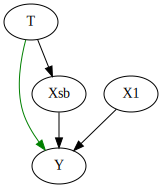

In [944]:
g = gr.Digraph()
g.edge("T", "Y", color = 'green')
g.edge("T", "Xsb")
g.edge("X1", "Y")
g.edge("Xsb", "Y")
g

## 3) Monte-Carlo experiment

### Parameters settings

In [945]:
# parameters settings
tau = -8  # true treatment effect
p = 10  # number of covariates generated
p0 = 1  # number of covariates used in DGP Y
corr = .5  # correlation between covariates
conf = False  # no confounder
flagX = True

First running 2 simple OLS regression under 'a' & 'b' conditions 

In [956]:
N = 100
const = np.ones([N, 1])
Yexp,T,Xsb,X = fn_gen_data(tau,N,p,p0,corr,conf,flagX)

model_a = sm.OLS(Yexp,np.concatenate([T,Xsb,X,const],axis = 1))  # under 'a' condition: control for the X_sb
reg_a = model_a.fit()

model_b = sm.OLS(Yexp,np.concatenate([T,X,const],axis = 1)) # under 'b' condition: not control for the X_sb
reg_b = model_b.fit()

print('Reg under condition "a": x1 is the treatment(i.e. T)','\n',reg_a.summary().tables[1],'\n')
print('Reg under condition "b": x1 is the treatment(i.e. T)','\n',reg_b.summary().tables[1])

Reg under condition "a": x1 is the treatment(i.e. T) 
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -11.9289      3.425     -3.483      0.001     -18.728      -5.130
x2             0.1109      0.094      1.177      0.242      -0.076       0.298
x3             2.2716      0.076     29.962      0.000       2.121       2.422
const          0.0255      0.140      0.181      0.856      -0.253       0.304

Reg under condition "b": x1 is the treatment(i.e. T) 
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -7.9053      0.199    -39.648      0.000      -8.301      -7.510
x2             2.2853      0.075     30.440      0.000       2.136       2.434
const          0.0221      0.141      0.157      0.876      -0.257       0.301


We can see that if controlling for the $X_{sb}$, estimated treatment effect is noisy, and if we remove $X_{sb}$, the estimated treatment effect is closer to its true value and with higher statistic significance

##### a. Control for the variable in between the path from cause to effect

In [957]:
# using the same parameters
estDict = {}  
R = 2000  

for N in [100, 1000]:
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)):  
        Yexp,T,Xsb,X = fn_gen_data(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,Xsb,X,const],axis = 1))  
        # controlling for the variable in between the path from cause to effect
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.12it/s]


In [958]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.05973781569390208, RMSE=3.5244676351154087, size=0.061
N=1000: bias=0.029018453251028593, RMSE=1.1225021148888013, size=0.062


##### b. Not control for the variable in between the path from cause to effect

In [959]:
# using the same parameters
estDict = {}  
R = 2000  

for N in [100, 1000]:
    tauhats = []
    sehats = []
    const = np.ones([N, 1])
    for r in tqdm(range(R)):  
        Yexp,T,Xsb,X = fn_gen_data(tau,N,p,p0,corr,conf,flagX)
        model = sm.OLS(Yexp,np.concatenate([T,X,const],axis = 1))  
        # not controlling for the variable in between the path from cause to effect
        reg = model.fit()
        tauhat = reg.params[0]
        se_tauhat = reg.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:25<00:00, 77.73it/s]


In [967]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.10675446322033415, RMSE=0.224529551596588, size=0.0815
N=1000: bias=0.10844078912990622, RMSE=0.12529391276442256, size=0.406


**Compareing the one that controlling for the variable in between the path from cause to effect (a.), the RMSE is smaller when we not control the variable in between the path from cause to effect(b.)**

## 4) Real-life situation example

When we studying the effect of getting **master's degree** on **wage**, there is a potential variable like being a **banker**, which is affected by the master's degree but won't affect master's degree, that may explain the outcome wage, and there is also a covariate like **GDP** will also affect the wage. Then if we add banker in the regression, we will face the selection bias problem.

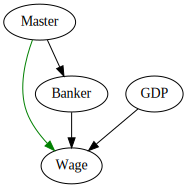

In [984]:
g = gr.Digraph()
g.edge("Master", "Wage", color = 'green')
g.edge("Master", "Banker")
g.edge("GDP", "Wage")
g.edge("Banker", "Wage")
g